In [ ]:
import numpy as np

import pandas as pd

import albumentations as A
from albumentations.augmentations.geometric.resize import Resize

import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

plt.style.use("dark_background")

import matplotlib.pyplot as plt

from code_prj.data import BuildDataset
from code_prj.model_light import Model_Light

device = 'cuda:1' if torch.cuda.is_available else 'cpu'

In [ ]:
folder = "data/CMP_facade_DB_base/base"
val = pd.read_csv("data/val.csv")["values"].to_list()

In [ ]:
transform = Resize(1024, 1024)

In [ ]:
test_data = BuildDataset(folder, val, transform, tr_chance=-1)
test_load = DataLoader(test_data, batch_size=2, num_workers=24)

In [ ]:
model = Model_Light.load_from_checkpoint("model_for_test.ckpt")
model_torch = model.model

In [ ]:
model_torch.to(device)
print()

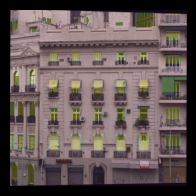

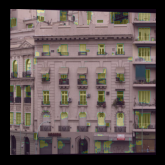

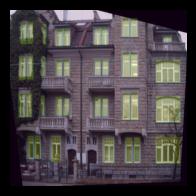

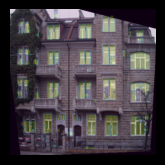

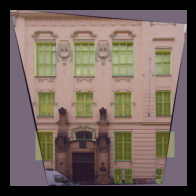

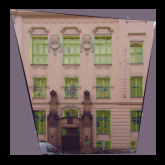

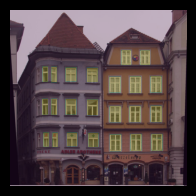

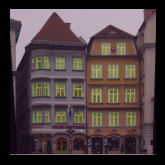

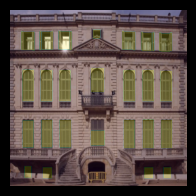

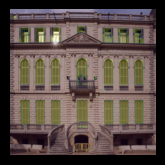

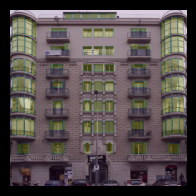

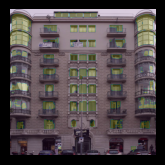

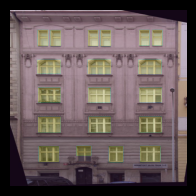

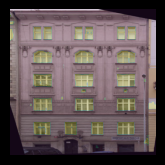

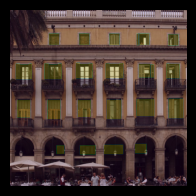

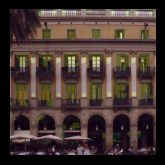

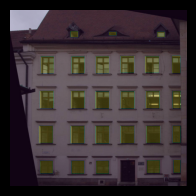

KeyboardInterrupt: 

In [12]:
test_load = DataLoader(val, batch_size=1, num_workers=24)

for batch in test_data:
    with torch.no_grad():
        img = batch["img"]
        x = batch["img_x"]
        y = batch["img_y"][None, :, :]
        x = x[None, :, :, :].to(device)
        pred = model(x)
        pred = pred.to("cpu")

        seg_prediction = pred.permute(0, 2, 3, 1).argmax(3)
        seg_prediction = torch.squeeze(seg_prediction, dim=0)

        # x = np.array(torch.squeeze(x).permute(1, 2, 0), dtype='uint8')
        y = np.array(y.permute(1, 2, 0), dtype="uint8")
        pred = np.array(torch.squeeze(pred, dim=0).permute(1, 2, 0), dtype="uint8")

        plt.figure(figsize=(5, 5))
        # display_indices = indices[:count]
        # if title:
        #     plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))

        # plt.subplot(1, 3, 1)
        # plt.imshow(x)
        # plt.grid(False)
        # plt.axis('off')

        # plt.subplot(1, 5, 1)
        # plt.imshow(img)
        # plt.grid(False)
        # plt.axis("off")

        # plt.subplot(1, 5, 2)
        # plt.imshow(y)
        # plt.grid(False)
        # plt.axis("off")

        # plt.subplot(1, 5, 3)
        # plt.imshow(seg_prediction)
        # plt.grid(False)
        # plt.axis("off")
        # plt.show()

        plt.subplot(1, 3, 2)
        plt.imshow(img)
        plt.imshow(seg_prediction, alpha=0.2)
        plt.grid(False)
        plt.axis("off")
        plt.show()

        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.imshow(y, alpha=0.2)
        plt.grid(False)
        plt.axis("off")
        plt.show()



In [71]:
import os
import cv2
from PIL import Image
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import compute_unary, unary_from_softmax
import numpy as np
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
import torch

In [72]:
seq = iaa.Sequential([iaa.SaltAndPepper(0.05)])

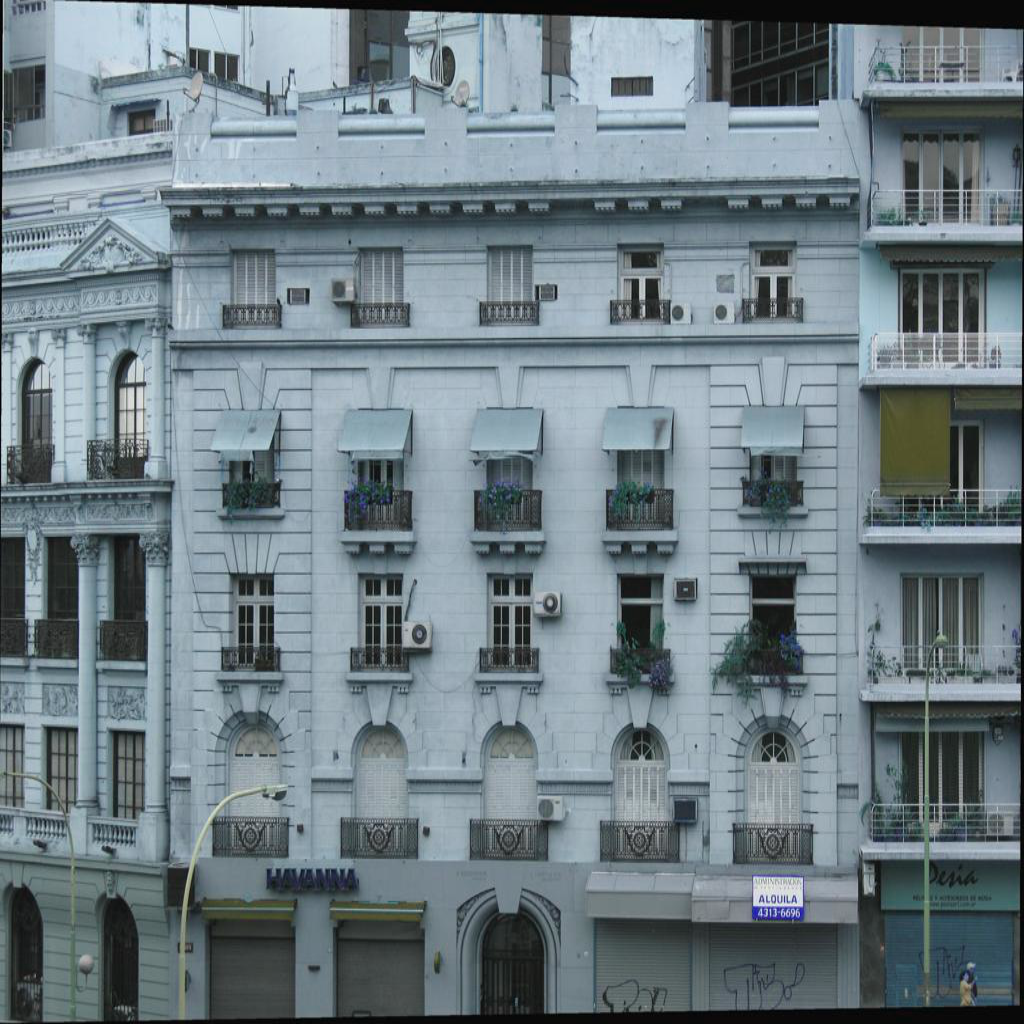

In [13]:
cat_bgr = img
cat_rgb = cv2.cvtColor(cat_bgr, cv2.COLOR_BGR2RGB)
display(Image.fromarray(cat_rgb))

In [14]:
print(cat_rgb.shape)

(1024, 1024, 3)


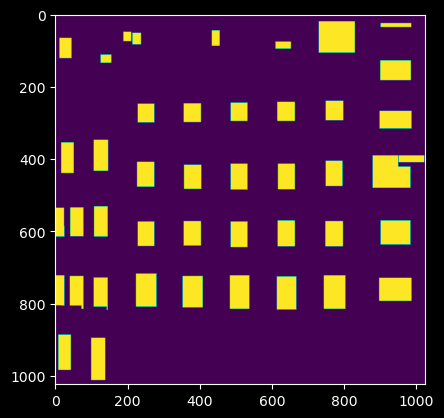

In [15]:
plt.imshow(y)

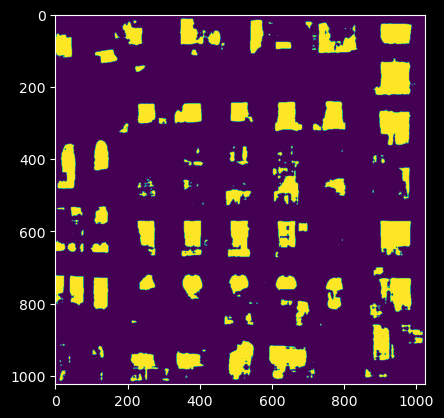

In [16]:
cat_mask = seg_prediction
plt.imshow(cat_mask)

https://github.com/seth814/Semantic-Shapes/blob/master/CRF%20Cat%20Demo.ipynb

In [ ]:
import os
import cv2
from PIL import Image
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import compute_unary, unary_from_softmax
import numpy as np
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

import torch.nn.functional as F

In [18]:
seq = iaa.Sequential([iaa.SaltAndPepper(0.05)])

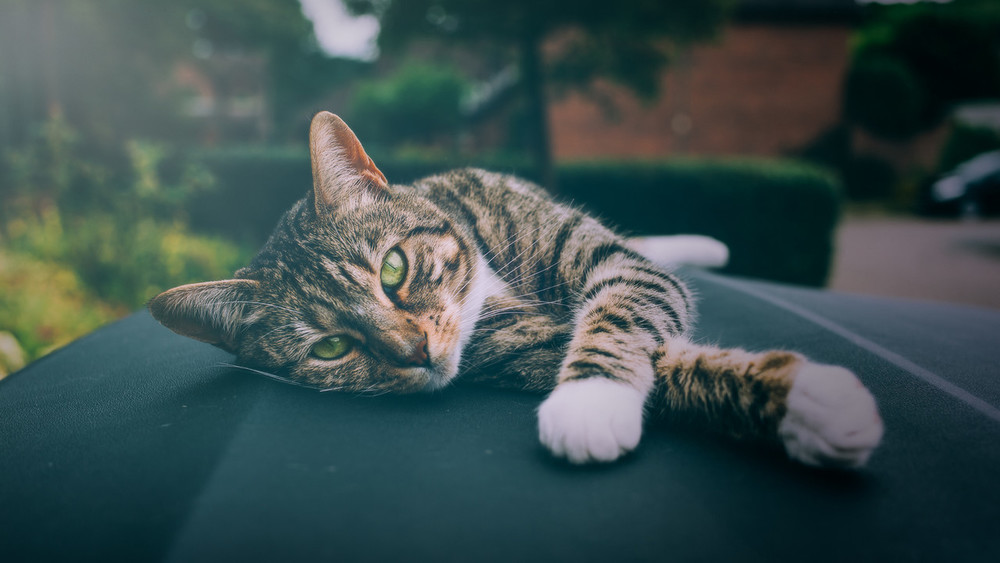

In [19]:
cat_path = os.path.join("cat.jpg")
cat_bgr = cv2.imread(cat_path, 1)
cat_rgb = cv2.cvtColor(cat_bgr, cv2.COLOR_BGR2RGB)
display(Image.fromarray(cat_rgb))

In [20]:
print(cat_rgb.shape)

(563, 1000, 3)


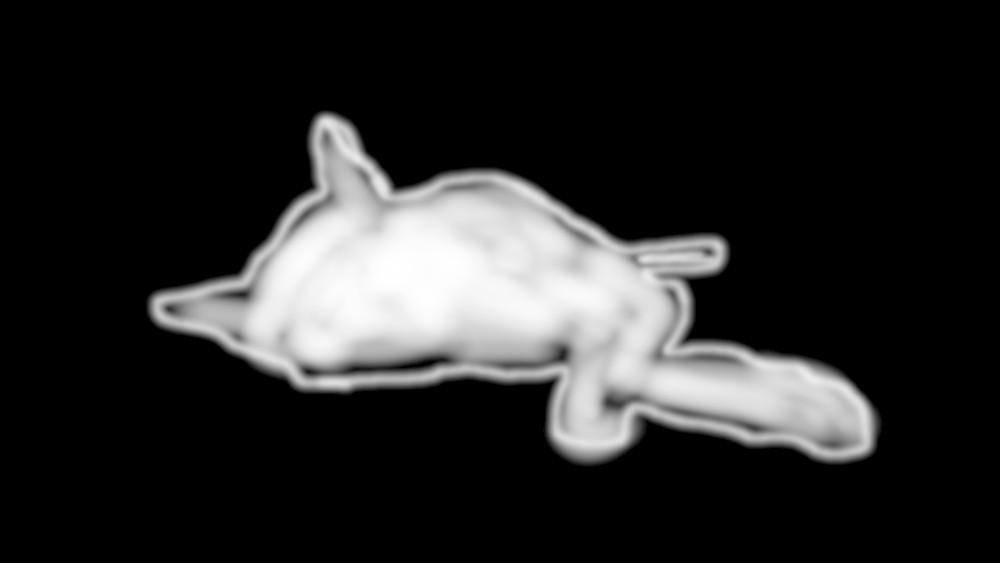

In [21]:
cat_mask_path = os.path.join("cat_mask.jpg")
cat_mask = cv2.imread(cat_mask_path, 0)
# cat_mask = seq.augment_image(np.array(cat_mask, dtype=np.uint8))
display(Image.fromarray(cat_mask))

In [22]:
not_mask = cv2.bitwise_not(cat_mask)
not_mask = np.expand_dims(not_mask, axis=2)
cat_mask = np.expand_dims(cat_mask, axis=2)

In [32]:
cat_mask

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8)

In [23]:
im_softmax = np.concatenate([not_mask, cat_mask], axis=2)
im_softmax = im_softmax / 255.0
print(im_softmax.shape)

(563, 1000, 2)


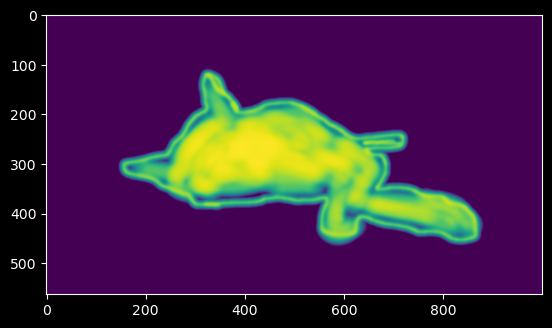

In [24]:
plt.imshow(im_softmax[:, :, 1])

In [34]:
im_softmax.shape

(563, 1000, 2)

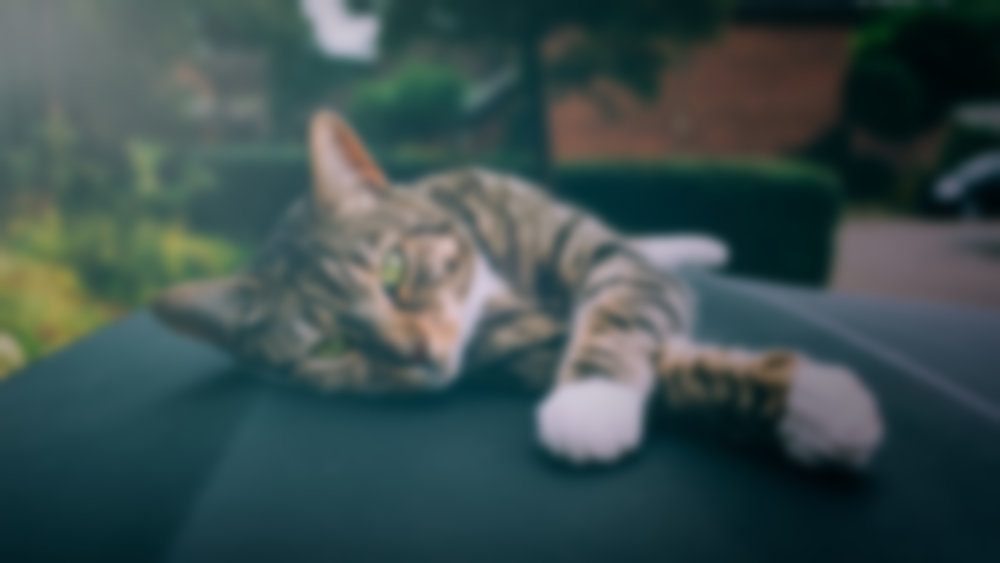

In [25]:
gauss_cat = cv2.GaussianBlur(cat_rgb, (31, 31), 0)
display(Image.fromarray(gauss_cat))

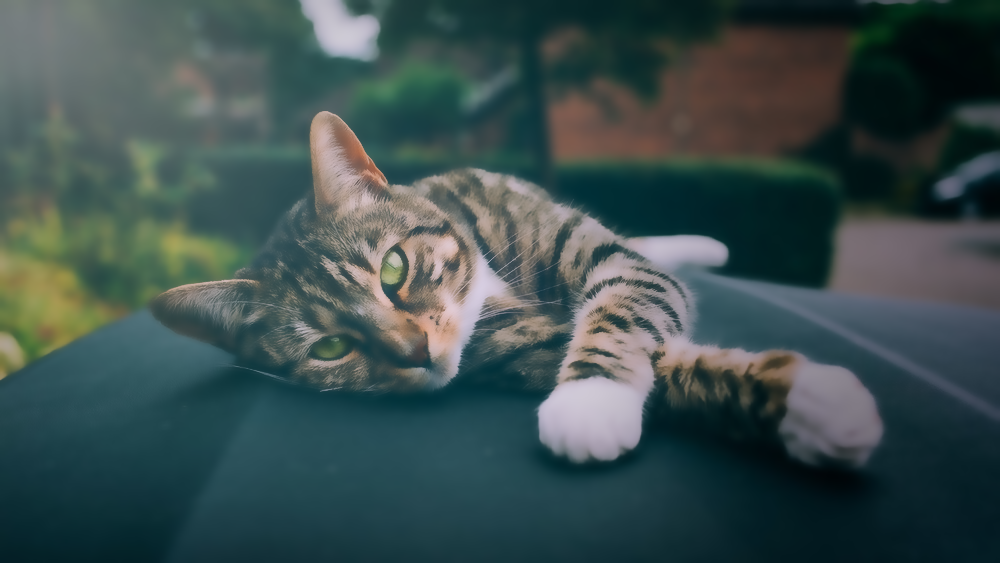

In [26]:
bilat_cat = cv2.bilateralFilter(cat_rgb, d=10, sigmaColor=80, sigmaSpace=80)
display(Image.fromarray(bilat_cat))

In [54]:
n_classes = 2
print(im_softmax.shape)
feat_first = im_softmax.transpose((2, 0, 1)).reshape((n_classes, -1))
print(feat_first.shape)
unary = unary_from_softmax(feat_first)
unary = np.ascontiguousarray(unary)

d = dcrf.DenseCRF2D(cat_rgb.shape[1], cat_rgb.shape[0], n_classes)

d.setUnaryEnergy(unary)
d.addPairwiseGaussian(
    sxy=(5, 5),
    compat=30,
    kernel=dcrf.DIAG_KERNEL,
    normalization=dcrf.NORMALIZE_SYMMETRIC,
)

d.addPairwiseBilateral(
    sxy=(5, 5),
    srgb=(41, 41, 41),
    rgbim=cat_rgb,
    compat=100,
    kernel=dcrf.DIAG_KERNEL,
    normalization=dcrf.NORMALIZE_SYMMETRIC,
)
Q = d.inference(5)
res = np.argmax(Q, axis=0).reshape((cat_rgb.shape[0], cat_rgb.shape[1]))
print(res.shape)

(563, 1000, 2)
(2, 563000)
(563, 1000)


In [56]:
cat_rgb.shape[1], cat_rgb.shape[0]

(1000, 563)

In [ ]:
seg_prediction = F.one_hot(seg_prediction)
seg_prediction = seg_prediction.numpy()
seg_prediction.shape

In [85]:
n_classes = 2
print(seg_prediction.shape)
feat_first = seg_prediction.transpose((2, 0, 1)).reshape((n_classes, -1))
print(feat_first.shape)
unary = unary_from_softmax(feat_first)
unary = np.ascontiguousarray(unary)

d = dcrf.DenseCRF2D(img.shape[1], img.shape[0], n_classes)

d.setUnaryEnergy(unary)
d.addPairwiseGaussian(
    sxy=(500, 500),
    compat=3,
    kernel=dcrf.DIAG_KERNEL,
    normalization=dcrf.NORMALIZE_SYMMETRIC,
)

d.addPairwiseBilateral(
    sxy=(100, 100),
    srgb=(13, 13, 13),
    rgbim=img,
    compat=10,
    kernel=dcrf.DIAG_KERNEL,
    normalization=dcrf.NORMALIZE_SYMMETRIC,
)
Q = d.inference(5)
res = np.argmax(Q, axis=0).reshape((img.shape[0], img.shape[1]))
print(res.shape)

(1024, 1024, 2)
(2, 1048576)
(1024, 1024)


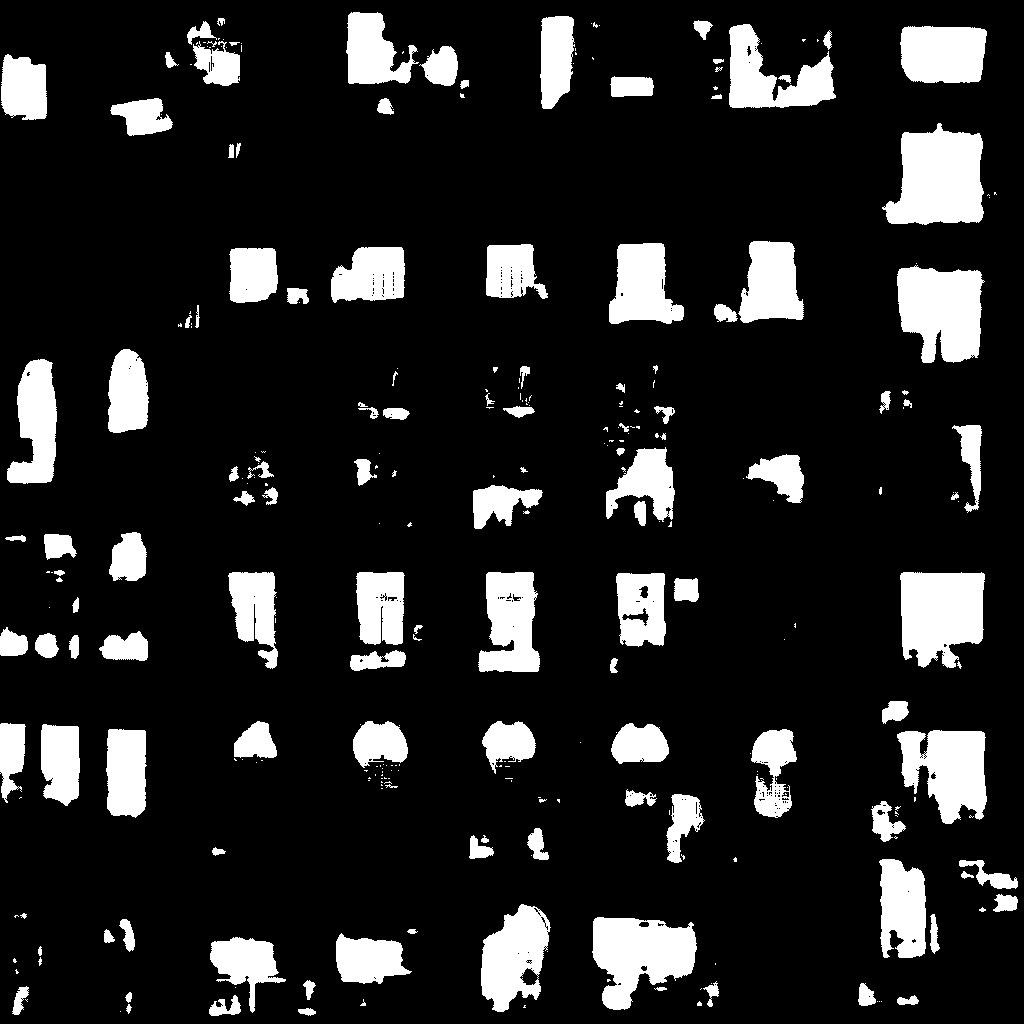

In [86]:
crf_mask = np.array(res * 255, dtype=np.uint8)
display(Image.fromarray(crf_mask))

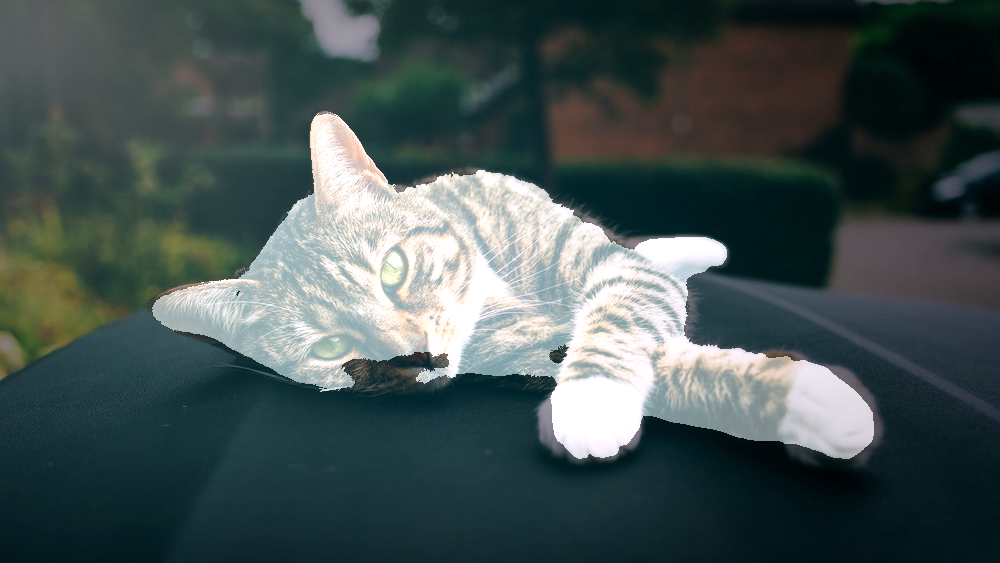

In [60]:
crf_rgb = cv2.cvtColor(crf_mask, cv2.COLOR_GRAY2RGB)
im = cv2.addWeighted(crf_rgb, 0.5, cat_rgb, 0.75, 0)
display(Image.fromarray(im))